# Input Modeling for Warehouse Task Arrivals

This notebook models **Task Interarrival Time (seconds)** for the warehouse demand process.

Significance: interarrival times control agent density on the floor; higher density increases collision/congestion risk and stresses MAPF policies.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_theme(style='whitegrid')

Matplotlib is building the font cache; this may take a moment.


In [2]:
csv_path = '../data/task_demand.csv'
df = pd.read_csv(csv_path)
df.head()

,Task_ID,Timestamp,Interarrival_Time,Regime
0,1,6.380,6.380,base
1,2,10.338,3.958,base
2,3,13.044,2.706,base
3,4,17.543,4.499,base
4,5,43.676,26.133,base


In [3]:
x = df['Interarrival_Time'].to_numpy(dtype=float)
x = x[x > 0]  # distributions here are defined for positive support

summary = {
    'n': len(x),
    'unit': 'seconds',
    'mean': np.mean(x),
    'std': np.std(x, ddof=1),
    'min': np.min(x),
    'max': np.max(x),
    'p95': np.quantile(x, 0.95),
}
summary

{'n': 3225,
 'unit': 'seconds',
 'mean': np.float64(8.925080930232557),
 'std': np.float64(33.02338274336047),
 'min': np.float64(0.007),
 'max': np.float64(1804.687),
 'p95': np.float64(27.1158)}

## EDA
Expected shape: right-skewed with many short intervals and a long tail. Long-tail values represent natural lulls (not data errors).

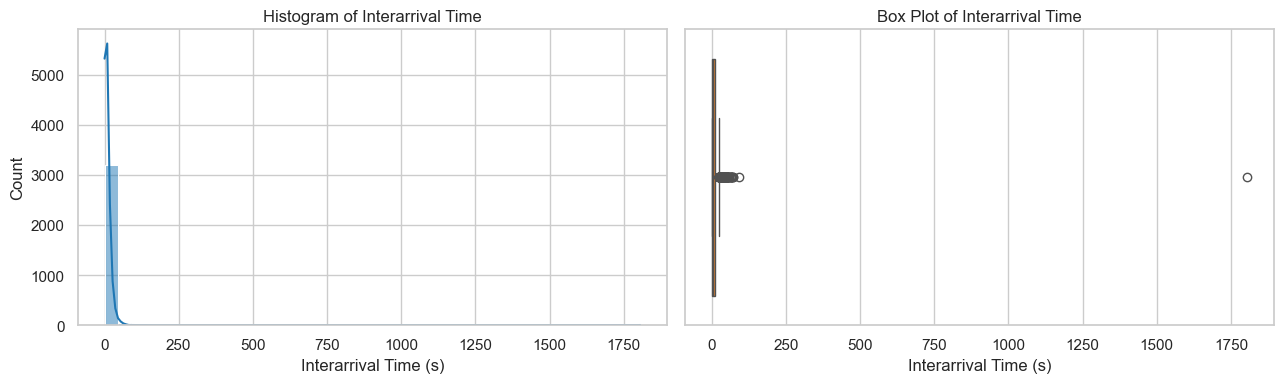

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
sns.histplot(x, bins=40, kde=True, ax=ax[0], color='#1f77b4')
ax[0].set_title('Histogram of Interarrival Time')
ax[0].set_xlabel('Interarrival Time (s)')

sns.boxplot(x=x, ax=ax[1], color='#ff7f0e')
ax[1].set_title('Box Plot of Interarrival Time')
ax[1].set_xlabel('Interarrival Time (s)')

plt.tight_layout()

## Candidate Distributions
We evaluate: **Exponential**, **Gamma**, and **Weibull**.

In [5]:
fit = {}
fit['Exponential'] = stats.expon.fit(x, floc=0)
fit['Gamma'] = stats.gamma.fit(x, floc=0)
fit['Weibull'] = stats.weibull_min.fit(x, floc=0)
fit

{'Exponential': (0.0, 8.925080930232557),
 'Gamma': (0.8170942567649407, 0, np.float64(10.922951491017637)),
 'Weibull': (np.float64(0.8451721521859589), 0, np.float64(8.007760018690147))}

In [6]:
def ad_statistic(sample, cdf_fn):
    y = np.sort(sample)
    n = len(y)
    i = np.arange(1, n + 1)
    F = np.clip(cdf_fn(y), 1e-12, 1 - 1e-12)
    return -n - np.mean((2 * i - 1) * (np.log(F) + np.log(1 - F[::-1])))

def chi_square_gof(sample, cdf_fn, bins=10, estimated_params=1):
    n = len(sample)
    quantiles = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(sample, quantiles))
    if len(edges) < 4:
        edges = np.histogram_bin_edges(sample, bins='fd')

    observed, _ = np.histogram(sample, bins=edges)
    expected = n * np.diff(cdf_fn(edges))
    expected = np.clip(expected, 1e-8, None)
    expected = expected * (n / expected.sum())

    chi2_stat = np.sum((observed - expected) ** 2 / expected)
    dof = max(len(observed) - 1 - estimated_params, 1)
    p_value = 1 - stats.chi2.cdf(chi2_stat, dof)
    return chi2_stat, p_value

results = []
for name, params in fit.items():
    if name == 'Exponential':
        dist = stats.expon
        param_count = 1
        ks = stats.kstest(x, 'expon', args=params)
    elif name == 'Gamma':
        dist = stats.gamma
        param_count = 2
        ks = stats.kstest(x, 'gamma', args=params)
    else:
        dist = stats.weibull_min
        param_count = 2
        ks = stats.kstest(x, 'weibull_min', args=params)

    cdf_fn = lambda v, d=dist, p=params: d.cdf(v, *p)
    chi2_stat, chi2_p = chi_square_gof(x, cdf_fn, bins=10, estimated_params=param_count)
    ad = ad_statistic(x, cdf_fn)

    results.append({
        'Distribution': name,
        'KS_Statistic': ks.statistic,
        'KS_pvalue': ks.pvalue,
        'Chi2_Statistic': chi2_stat,
        'Chi2_pvalue': chi2_p,
        'AD_Statistic': ad,
    })

gof = pd.DataFrame(results).sort_values('KS_Statistic').reset_index(drop=True)
gof

,Distribution,KS_Statistic,KS_pvalue,Chi2_Statistic,Chi2_pvalue,AD_Statistic
0,Weibull,0.028363,1.094286e-02,37.505823,3.761246e-06,6.656413
1,Gamma,0.038643,1.275549e-04,37.654530,3.524551e-06,7.742340
2,Exponential,0.062368,2.388425e-11,60.585915,3.576689e-10,25.125156


/Users/adityadutta/Desktop/GitHub/GNN-Warehouse-Sim/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:2760: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


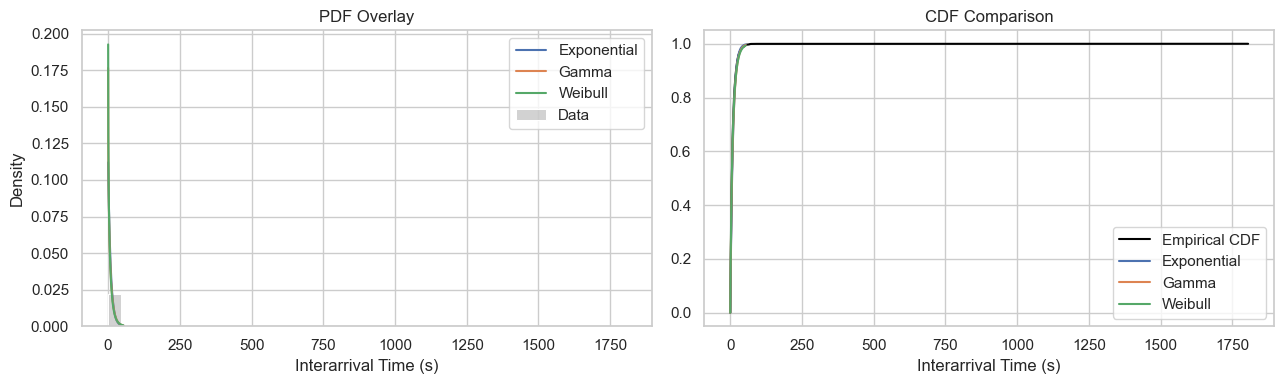

In [7]:
grid = np.linspace(0, np.quantile(x, 0.995), 400)

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.histplot(x, bins=40, stat='density', alpha=0.35, ax=ax[0], color='gray', label='Data')
for name, params in fit.items():
    if name == 'Exponential':
        y = stats.expon.pdf(grid, *params)
    elif name == 'Gamma':
        y = stats.gamma.pdf(grid, *params)
    else:
        y = stats.weibull_min.pdf(grid, *params)
    ax[0].plot(grid, y, label=name)
ax[0].set_title('PDF Overlay')
ax[0].set_xlabel('Interarrival Time (s)')
ax[0].legend()

ecdf_y = np.arange(1, len(np.sort(x)) + 1) / len(x)
ax[1].plot(np.sort(x), ecdf_y, label='Empirical CDF', color='black')
for name, params in fit.items():
    if name == 'Exponential':
        y = stats.expon.cdf(grid, *params)
    elif name == 'Gamma':
        y = stats.gamma.cdf(grid, *params)
    else:
        y = stats.weibull_min.cdf(grid, *params)
    ax[1].plot(grid, y, label=name)
ax[1].set_title('CDF Comparison')
ax[1].set_xlabel('Interarrival Time (s)')
ax[1].legend()

plt.tight_layout()